<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Reinforcement Learning

**OLS Regression & Efficient Markets**

&copy; Dr Yves J Hilpisch | The Python Quants GmbH

http://tpq.io | http://twitter.com/dyjh

<img src="https://hilpisch.com/aiif_cover_shadow.png" width="300px" align="left">

## Imports

In [1]:
import math
import cufflinks
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
cufflinks.set_config_file(offline=True)

## Random Walks

Eugene F. Fama (1965): “Random Walks in Stock Market Prices”:

> “For many years, economists, statisticians, and teachers of finance have been interested in developing and testing models of stock price behavior. One important model that has evolved from this research is the theory of random walks. This theory casts serious doubt on many other methods for describing and predicting stock price behavior—methods that have considerable popularity outside the academic world. For example, we shall see later that, if the random-walk theory is an accurate description of reality, then the various “technical” or “chartist” procedures for predicting stock prices are completely without value.”

Michael Jensen (1978): “Some Anomalous Evidence Regarding Market Efficiency”:

>“A market is efficient with respect to an information set S if it is impossible to make economic profits by trading on the basis of information set S.”

If a stock price follows a (simple) random walk (no drift & normally distributed returns), then it rises and falls with the same probability of 50% (“toss of a coin”).

**In such a case, the best predictor of tomorrow’s stock price — in a least-squares sense — is today’s stock price.**

### Retrieving Cross-Asset Data

In [2]:
url = 'https://certificate.tpq.io/eod.csv'

In [3]:
data = pd.read_csv(url, index_col=0, parse_dates=True)

In [4]:
del data['BTC=']

In [5]:
data.dropna(inplace=True)

In [6]:
data.head()

AAPL.O  MSFT.O  INTC.O  AMZN.O    GS.N     SPY     .SPX   .VIX  \
Date                                                                            
2012-04-02  22.093906   32.29   28.38  198.05  124.90  141.84  1419.04  15.64   
2012-04-03  22.475692   31.94   28.11  199.66  122.71  141.26  1413.38  15.66   
2012-04-04  22.296763   31.21   27.93  193.99  119.96  139.86  1398.96  16.44   
2012-04-05  22.631406   31.52   28.07  194.39  118.00  139.79  1398.08  16.70   
2012-04-09  22.722477   31.10   27.76  191.87  117.02  138.22  1382.20  18.81   

              EUR=     XAU=     GDX     GLD  
Date                                         
2012-04-02  1.3321  1677.25  50.390  162.94  
2012-04-03  1.3233  1644.83  48.752  159.89  
2012-04-04  1.3141  1619.73  46.705  157.21  
2012-04-05  1.3063  1630.64  46.200  158.31  
2012-04-09  1.3100  1640.78  46.480  159.37

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2012-04-02 to 2022-03-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2515 non-null   float64
 1   MSFT.O  2515 non-null   float64
 2   INTC.O  2515 non-null   float64
 3   AMZN.O  2515 non-null   float64
 4   GS.N    2515 non-null   float64
 5   SPY     2515 non-null   float64
 6   .SPX    2515 non-null   float64
 7   .VIX    2515 non-null   float64
 8   EUR=    2515 non-null   float64
 9   XAU=    2515 non-null   float64
 10  GDX     2515 non-null   float64
 11  GLD     2515 non-null   float64
dtypes: float64(12)
memory usage: 255.4 KB


### Calculating the Log Returns

In [8]:
rets = np.log(data / data.shift(1))

In [9]:
rets.head()

AAPL.O    MSFT.O    INTC.O    AMZN.O      GS.N       SPY  \
Date                                                                     
2012-04-02       NaN       NaN       NaN       NaN       NaN       NaN   
2012-04-03  0.017133 -0.010898 -0.009559  0.008096 -0.017690 -0.004097   
2012-04-04 -0.007993 -0.023121 -0.006424 -0.028809 -0.022665 -0.009960   
2012-04-05  0.014897  0.009884  0.005000  0.002060 -0.016474 -0.000501   
2012-04-09  0.004016 -0.013414 -0.011105 -0.013048 -0.008340 -0.011295   

                .SPX      .VIX      EUR=      XAU=       GDX       GLD  
Date                                                                    
2012-04-02       NaN       NaN       NaN       NaN       NaN       NaN  
2012-04-03 -0.003997  0.001278 -0.006628 -0.019519 -0.033047 -0.018896  
2012-04-04 -0.010255  0.048608 -0.006977 -0.015378 -0.042895 -0.016904  
2012-04-05 -0.000629  0.015691 -0.005953  0.006713 -0.010871  0.006973  
2012-04-09 -0.011423  0.118980  0.002828  0.006199  0.006042  0.006673

In [10]:
rets.mean() * 252  # annualized, average log returns

AAPL.O    0.209685
MSFT.O    0.228456
INTC.O    0.061181
AMZN.O    0.284575
GS.N      0.100282
SPY       0.118271
.SPX      0.118574
.VIX      0.018978
EUR=     -0.018419
XAU=      0.013507
GDX      -0.027709
GLD       0.009501
dtype: float64

### Plotting the Data

`pip install cufflinks`

In [11]:
data.normalize().iplot(kind='lines')

In [12]:
rets.iplot(kind='histogram', subplots=True)

In [13]:
rets.corr().iplot(kind='heatmap', colorscale='blues')

### Preparing Lagged Data

In [17]:
def add_lags(data, ric, lags):
    # ric means the column name of the dataframe
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)  # defines the column name
        df[col] = df[ric].shift(lag)  # creates the lagged data column
        cols.append(col)  # stores the column name
    df.dropna(inplace=True)  # gets rid of incomplete data rows
    return df, cols

In [18]:
lags = 7  # seven historical lags

In [19]:
dfs = {}
for sym in data.columns:
    df, cols = add_lags(data, sym, lags)
    dfs[sym] = df

In [20]:
cols  # the column names for the lags

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']

In [23]:
dfs.keys()  # the keys of the dictonary

dict_keys(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX', 'EUR=', 'XAU=', 'GDX', 'GLD'])

In [24]:
dfs['AAPL.O'].head(7)

AAPL.O      lag_1      lag_2      lag_3      lag_4      lag_5  \
Date                                                                           
2012-04-12  22.241763  22.364263  22.444263  22.722477  22.631406  22.296763   
2012-04-13  21.615336  22.241763  22.364263  22.444263  22.722477  22.631406   
2012-04-16  20.718908  21.615336  22.241763  22.364263  22.444263  22.722477   
2012-04-17  21.774978  20.718908  21.615336  22.241763  22.364263  22.444263   
2012-04-18  21.726407  21.774978  20.718908  21.615336  22.241763  22.364263   
2012-04-19  20.979979  21.726407  21.774978  20.718908  21.615336  22.241763   
2012-04-20  20.463551  20.979979  21.726407  21.774978  20.718908  21.615336   

                lag_6      lag_7  
Date                              
2012-04-12  22.475692  22.093906  
2012-04-13  22.296763  22.475692  
2012-04-16  22.631406  22.296763  
2012-04-17  22.722477  22.631406  
2012-04-18  22.444263  22.722477  
2012-04-19  22.364263  22.444263  
2012-04-20  22.241763  22.364263

### Implementing OLS Regression

In [27]:
regs = {}
for sym in data.columns:
    df = dfs[sym]  # getting data for the RIC
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]  # the OLS regression
    regs[sym] = reg  # storing the results

In [31]:
np.set_printoptions(suppress=True)

In [33]:
for sym in data.columns:
    print('{:10} | {}'.format(sym, regs[sym].round(4)))

AAPL.O     | [ 0.9597  0.0459 -0.0511  0.0417  0.0366 -0.0723  0.0408]
MSFT.O     | [ 0.8249  0.2034 -0.0377 -0.0156  0.0214 -0.0886  0.0935]
INTC.O     | [ 0.8313  0.2296 -0.0059 -0.0808  0.0131 -0.0478  0.0604]
AMZN.O     | [ 0.9736  0.0283 -0.0823  0.0954 -0.0196  0.0052  0.0001]
GS.N       | [ 0.9876  0.0537 -0.0571 -0.0254  0.0368  0.0209 -0.0162]
SPY        | [ 0.8974  0.167  -0.0715 -0.0511  0.0855 -0.1144  0.0878]
.SPX       | [ 0.8792  0.1964 -0.0819 -0.0546  0.0883 -0.1178  0.0911]
.VIX       | [ 0.8264  0.1904  0.0165 -0.1205  0.0686 -0.0121  0.0271]
EUR=       | [ 0.9802  0.032  -0.0273  0.0194  0.0024 -0.0498  0.043 ]
XAU=       | [ 1.0189 -0.0293  0.0182 -0.0491  0.0033  0.0391 -0.001 ]
GDX        | [ 0.9659 -0.0073  0.0357 -0.018  -0.0193  0.0381  0.0043]
GLD        | [ 1.0211 -0.0367  0.0172 -0.0363  0.0019  0.0216  0.0112]


In [34]:
rega = np.stack(tuple(regs.values()))  # combines the regression results # dictionary to nd.array

In [35]:
rega.mean(axis=0)  # mean values by column

array([ 0.93051879,  0.08944553, -0.02726397, -0.02456945,  0.02657988,
       -0.03149543,  0.03683105])

In [43]:
regd = pd.DataFrame(rega, columns=cols, index=data.columns)  # converting the results to DataFrame

In [44]:
regd

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7
AAPL.O  0.959679  0.045927 -0.051114  0.041716  0.036574 -0.072273  0.040829
MSFT.O  0.824875  0.203449 -0.037685 -0.015592  0.021389 -0.088649  0.093494
INTC.O  0.831301  0.229590 -0.005864 -0.080759  0.013148 -0.047764  0.060415
AMZN.O  0.973598  0.028261 -0.082269  0.095425 -0.019603  0.005160  0.000116
GS.N    0.987644  0.053652 -0.057113 -0.025353  0.036777  0.020920 -0.016242
SPY     0.897405  0.166956 -0.071468 -0.051136  0.085482 -0.114428  0.087763
.SPX    0.879203  0.196426 -0.081939 -0.054622  0.088263 -0.117822  0.091073
.VIX    0.826368  0.190368  0.016461 -0.120532  0.068586 -0.012148  0.027077
EUR=    0.980226  0.031969 -0.027277  0.019380  0.002419 -0.049762  0.042961
XAU=    1.018889 -0.029307  0.018175 -0.049075  0.003266  0.039131 -0.001026
GDX     0.965947 -0.007253  0.035720 -0.017993 -0.019268  0.038105  0.004309
GLD     1.021091 -0.036692  0.017204 -0.036291  0.001926  0.021585  0.011204

In [45]:
regd.iplot(kind='bar')

In [46]:
regd.mean().iplot(kind='bar')

## Another Approach

In [47]:
import statsmodels.api as sm

In [52]:
x_ = sm.add_constant(df[cols[:]], prepend=False)

In [54]:
y = df[sym]

In [55]:
mod = sm.OLS(y, x_)
reg = mod.fit()

In [56]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.037e+05
Date:                Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:53:44   Log-Likelihood:                -4263.5
No. Observations:                2508   AIC:                             8543.
Df Residuals:                    2500   BIC:                             8590.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          1.0207      0.020     51.038      0.000       0.981       1.060
lag_2         -0.0367      0.029     -1.282      0.200      -0.093       0.019
lag_3          0.0172      0.029      0.601      0.548      -0.039       0.073
lag_4         -0.0363      0.029     -1.269      0.205      -0.092       0.020
lag_5          0.0019      0.029      0.065      0.948      -0.054       0.058
lag_6          0.0216      0.029      0.755      0.451      -0.035       0.078
lag_7          0.0105      0.020      0.526      0.599      -0.029       0.050
const          0.1553      0.162      0.958      0.338      -0.163       0.473
==============================================================================
Omnibus:                      537.715   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5937.832
Skew:                          -0.687   Prob(JB):                         0.00
Kurtosis:                      10.412   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Cross Check

In [76]:
sym = 'AAPL.O'

In [77]:
reg = regd.loc[sym].values

In [78]:
y_ = np.dot(dfs[sym][cols], reg)  # predictions

In [79]:
r = y_ - dfs[sym][sym]  # residuals

Check for assumptions:
* **linearity**: given
* **independence**: <b style="color: red;">not at all</b>
* **zero mean**: somehow
* **no correlation**: given
* **homoscedasticity**: <b style="color: red;">not given</b>
* **no autocorrelation**: given
* **stationarity**: <b style="color: red;">not given</b>

### Correlation Matrix

In [43]:
dfs[sym][cols].corr()  # lags highly correlated

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7
lag_1  1.000000  0.999546  0.999130  0.998707  0.998328  0.997954  0.997556
lag_2  0.999546  1.000000  0.999544  0.999127  0.998705  0.998327  0.997957
lag_3  0.999130  0.999544  1.000000  0.999543  0.999126  0.998704  0.998330
lag_4  0.998707  0.999127  0.999543  1.000000  0.999543  0.999126  0.998708
lag_5  0.998328  0.998705  0.999126  0.999543  1.000000  0.999542  0.999126
lag_6  0.997954  0.998327  0.998704  0.999126  0.999542  1.000000  0.999542
lag_7  0.997556  0.997957  0.998330  0.998708  0.999126  0.999542  1.000000

In [81]:
r.mean()

0.0021271202282081712

In [82]:
np.corrcoef(r, dfs[sym]['lag_3'])

array([[ 1.        , -0.00207236],
       [-0.00207236,  1.        ]])

### Bartlett for Heterskedasticity

In [83]:
from scipy.stats import bartlett

In [84]:
split = int(len(dfs) / 2)

In [92]:
# the bartlett test the null hypothesis, sample has the same variance.
# here, we seperate our residual to be two sets, and input into bartlett, the output p value is 0.14
# , which means we cannot reject the null hypothesis at 10% significant level
# , and residuals in two sets have the same variance -> no heteroskedasticity (no rigorous for heterskedasticity)

bartlett(r[:split], r[split:])  # pvalue << 0.05 --> different variance

BartlettResult(statistic=2.14228090075987, pvalue=0.1432887090625374)

### ACF Correlogram

In [93]:
from statsmodels.graphics.tsaplots import plot_acf

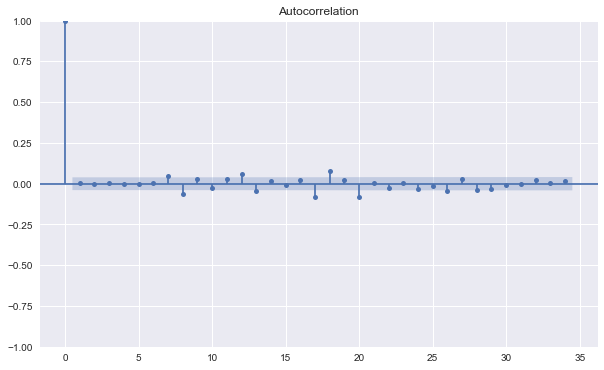

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(r, ax=ax);

### Augmented Dicky Fuller - for Stationarity

In [100]:
from statsmodels.tsa.stattools import adfuller

In [96]:
# adfuller?

In [101]:
adfuller(dfs[sym][sym])  # adf >> -2.567 --> not stationary

(2.16602284107071,
 0.9988533646257679,
 20,
 2487,
 {'1%': -3.4329821119179256,
  '5%': -2.862702850392563,
  '10%': -2.5673890307492004},
 8231.226317056447)

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>